In [200]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# Define experiments

In [126]:
experiments = {"rpl22_oe": [
    ['LNCaP_GFP_1',
     'LNCaP_GFP_2',
     'LNCaP_GFP_3'],
    ['LNCaP_RPL22_1',
     'LNCaP_RPL22_2',
     'LNCaP_RPL22_3']
],
    "rpl22l1_oe": [
    ['CAL851_GFP_1',
     'CAL851_GFP_2',
     'CAL851_GFP_3'],
    ['CAL851_RPL22L1_1',
     'CAL851_RPL22L1_2',
     'CAL851_RPL22L1_3']
],
    "sh704": [
    ['LNCaP_shLuc_1',
     'LNCaP_shLuc_2',
     'LNCaP_shLuc_3'],
    ['LNCaP_sh704_1',
     'LNCaP_sh704_2',
     'LNCaP_sh704_3']
],
    "sh705": [
    ['LNCaP_shLuc_1',
     'LNCaP_shLuc_2',
     'LNCaP_shLuc_3'],
    ['LNCaP_sh705_1',
     'LNCaP_sh705_2',
     'LNCaP_sh705_3']
]
}

experiment_ids = ["rpl22_oe","rpl22l1_oe","sh704","sh705"]

# Load TPMS and sleuth results

In [74]:
named_tpms = pd.read_hdf("../data/processed/tpm_matrix_named.hdf",key="named_tpms")

rpl22_oe_tpms = pd.read_hdf("../data/intermediate/kallisto_sleuth/RPL22_oe.hdf", key="rpl22_oe")
rpl22l1_oe_tpms = pd.read_hdf("../data/intermediate/kallisto_sleuth/RPL22L1_oe.hdf", key="rpl22l1_oe")
sh704_tpms = pd.read_hdf("../data/intermediate/kallisto_sleuth/sh704.hdf", key="sh704")
sh705_tpms = pd.read_hdf("../data/intermediate/kallisto_sleuth/sh705.hdf", key="sh705")

# Differential expression

In [166]:
def as_si(x, ndp):
    """
    Convert a number to scientific notation

    Parameters
    ----------
    x : float
        number to convert
    ndp: float
        number of decimal places

    Returns
    -------
    x_si : string
        x formatted in scientific notation
    """

    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    x_si = r'{m:s} × $10^{{{e:d}}}$'.format(m=m, e=int(e))

    return x_si

In [168]:
rpl22_oe_tpms["qval"]

,target_id,pval,qval,test_stat,rss,degrees_free,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,format_transcript_id,LNCaP_GFP_1,LNCaP_GFP_2,LNCaP_GFP_3,LNCaP_RPL22_1,LNCaP_RPL22_2,LNCaP_RPL22_3,gene_name
ENST00000471204.5,1,1.877825e-09,0.000115,36.096513,12.594414,1.0,8.072771,2.518883,0.003695,2.515188,0.006531,2.515188,RPL22_ENST00000471204.5,287.495000,309.53100,272.2680,4437.140000,5644.10000,5296.2900,RPL22
ENST00000234875.9,2,1.210131e-07,0.003697,28.004828,3.123811,1.0,8.793426,0.624762,0.000280,0.624483,0.009104,0.624483,RPL22_ENST00000234875.9,218.033000,240.06100,231.1750,856.984000,1010.34000,875.9550,RPL22
ENST00000295830.13,3,2.131862e-07,0.004342,26.909701,3.657392,1.0,5.508258,0.731478,0.006701,0.724777,0.009148,0.724777,RPL22L1_ENST00000295830.13,48.141400,43.28760,45.3857,9.211160,7.97729,10.1963,RPL22L1
ENST00000252444.9,4,4.569209e-07,0.006979,25.437618,0.596817,1.0,8.415739,0.119363,0.000637,0.118726,0.007484,0.118726,LDLR_ENST00000252444.9,125.821000,115.31600,120.0150,61.497700,56.80260,63.3210,LDLR
ENST00000536410.6,5,1.631579e-06,0.009191,22.986325,0.342527,1.0,7.509118,0.068505,0.000694,0.067811,0.005743,0.067811,DHRS7_ENST00000536410.6,191.140000,180.88700,179.2000,279.718000,272.07100,286.3890,DHRS7
ENST00000375078.4,6,8.177139e-07,0.009191,24.315664,0.416878,1.0,7.287693,0.083376,0.000762,0.082614,0.005650,0.082614,CAMK2N1_ENST00000375078.4,59.220600,63.19620,62.2455,99.126400,98.46440,97.0055,CAMK2N1
ENST00000494914.1,7,1.433208e-06,0.009191,23.235583,0.859594,1.0,6.397130,0.171919,0.002138,0.169781,0.006401,0.169781,DDC_ENST00000494914.1,75.052200,73.05490,66.2934,147.299000,142.78000,138.5610,DDC
ENST00000463836.1,8,1.373430e-06,0.009191,23.317523,3.917787,1.0,6.063296,0.783557,0.008408,0.775149,0.007171,0.775149,RPL22L1_ENST00000463836.1,388.307000,500.34200,513.2940,81.529300,82.44490,108.3450,RPL22L1
ENST00000265896.10,9,1.654611e-06,0.009191,22.959377,0.438307,1.0,8.417237,0.087661,0.000228,0.087433,0.007489,0.087433,SQLE_ENST00000265896.10,268.345000,269.48500,254.3950,139.482000,143.69900,154.8030,SQLE
ENST00000467076.5,10,1.192288e-06,0.009191,23.589622,0.462722,1.0,8.242870,0.092544,0.001864,0.090681,0.006951,0.090681,FDPS_ENST00000467076.5,540.851000,555.56900,544.3470,289.246000,298.09500,305.2390,FDPS


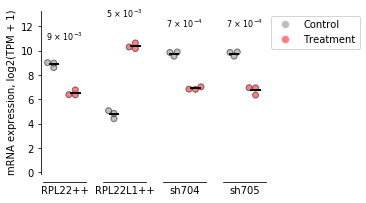

In [244]:
control_color = "grey"
treatment_color = "red"
alpha = 0.5

def plot_tpm_dist(transcript_id, experiment_id, diff_results, ax=None, pal=None, xlabel=None, ylabel=None):

    if ax is None:
        ax = plt.subplot(111)

    if pal is None:
        pal = sns.color_palette([control_color, treatment_color])

    if xlabel is None:
        xlabel = experiment_id

    if ylabel is None:
        ylabel = "mRNA expression, log2(TPM + 1)"

    select_abundance = diff_results.loc[transcript_id]

    controls = experiments[experiment_id][0]
    treatments = experiments[experiment_id][1]

    tpms = np.log2(select_abundance[controls+treatments].astype(np.float64)+1)

    expression_df = pd.DataFrame(index=controls+treatments)

    expression_df["tpm"] = tpms
    expression_df["treatment"] = ["control"] * \
        len(controls)+["treatment"]*len(treatments)

    sns.swarmplot(x="treatment",
                  y="tpm",
                  data=expression_df,
                  ax=ax,
                  palette=pal,
                  s=6,
                  alpha=alpha,
                  linewidth=1,
                  edgecolor="black",
                  )
    
    means = expression_df.groupby("treatment")["tpm"].mean()
    
    ax.axhline(means["control"], 0.15,0.35, linewidth=2, color="black", zorder=100)
    ax.axhline(means["treatment"], 0.65,0.85, linewidth=2, color="black", zorder=100)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))
    
    plt.ylim(0)
    
    y_max = max(tpms)
    
    if not np.isnan(select_abundance["qval"]):
    
        qval = as_si(select_abundance["qval"],0)
        ax.text(0.5, y_max*1.2, qval,ha="center",fontsize=8)

    return ax, y_max

def plot_tpm_dist_all(transcript_id):
        
    f, axes = plt.subplots(1, 4, sharey=True,figsize=(4,3))
    
    maxes = []
    
    ax = axes[0]
    ax, y_max = plot_tpm_dist(transcript_id, "rpl22_oe", rpl22_oe_tpms, ax=ax)
    maxes.append(y_max)
    ax.set_xlabel("RPL22++")
    
    ax = axes[1]
    ax, y_max = plot_tpm_dist(transcript_id, "rpl22l1_oe", rpl22l1_oe_tpms, ax=ax,ylabel="")
    maxes.append(y_max)
    ax.spines["left"].set_visible(False)
    ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    ax.set_xlabel("RPL22L1++")
    
    ax = axes[2]
    ax, y_max = plot_tpm_dist(transcript_id, "sh704", sh704_tpms, ax=ax,ylabel="") 
    maxes.append(y_max)
    ax.spines["left"].set_visible(False)
    ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    
    ax = axes[3]
    ax, y_max = plot_tpm_dist(transcript_id, "sh705", sh705_tpms, ax=ax,ylabel="") 
    maxes.append(y_max)
    ax.spines["left"].set_visible(False)
    ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

    plt.ylim(-0.1,max(maxes)*1.25)
    
    plt.subplots_adjust(wspace=0.4)
    
    legend_elements = [Line2D([0], [0], marker='o', color="white", label='Control',
                          markerfacecolor=control_color, markersize=8,alpha=alpha),
                   Line2D([0], [0], marker='o', color="white", label='Treatment',
                          markerfacecolor=treatment_color, markersize=8,alpha=alpha)]

    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    
plot_tpm_dist_all("ENST00000463836.1")

# Differential splicing

In [57]:
rpl22_oe_exons = pd.read_hdf("../data/intermediate/kallisto_sleuth/RPL22_oe.hdf", key="rpl22_oe")
rpl22l1_oe_exons = pd.read_hdf("../data/intermediate/kallisto_sleuth/RPL22L1_oe.hdf", key="rpl22l1_oe")
sh704_exons = pd.read_hdf("../data/intermediate/kallisto_sleuth/sh704.hdf", key="sh704")
sh705_exons = pd.read_hdf("../data/intermediate/kallisto_sleuth/sh705.hdf", key="sh705")

In [245]:
sh704_exons

,target_id,pval,qval,test_stat,rss,degrees_free,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,format_transcript_id,LNCaP_shLuc_1,LNCaP_shLuc_2,LNCaP_shLuc_3,LNCaP_sh704_1,LNCaP_sh704_2,LNCaP_sh704_3
ENST00000293894.4,1,2.634698e-09,0.000170,35.436741,9.132585,1.0,6.474152,1.826517,0.003414,1.823103,0.016601,1.823103,SOX8_ENST00000293894.4,4.74316,4.469490,4.35611,50.35160,52.50040,46.306100
ENST00000356644.7,2,7.433596e-09,0.000193,33.417917,3.072313,1.0,7.583306,0.614463,0.001110,0.613353,0.014000,0.613353,SESN1_ENST00000356644.7,41.23930,44.704000,41.53700,154.77900,166.87900,162.233000
ENST00000244741.9,3,8.962790e-09,0.000193,33.054142,3.490825,1.0,8.732806,0.698165,0.002049,0.696116,0.014693,0.696116,CDKN1A_ENST00000244741.9,102.89800,109.302000,99.68700,442.31400,444.29700,434.015000
ENST00000515896.1,4,2.478953e-08,0.000401,31.077762,7.954752,1.0,7.434212,1.590950,0.001022,1.589929,0.014157,1.589929,RNA5-8SP6_ENST00000515896.1,1870.97000,1606.200000,1600.61000,15361.30000,13488.80000,17269.000000
ENST00000290551.5,5,6.216386e-08,0.000502,29.294751,1.558509,1.0,7.283794,0.311702,0.000864,0.310838,0.014373,0.310838,BTG2_ENST00000290551.5,30.03560,28.238900,26.15460,72.36050,71.33070,69.864700
ENST00000312584.4,6,4.586702e-08,0.000502,29.884051,1.423671,1.0,7.540829,0.284734,0.000635,0.284099,0.014039,0.284099,TNFRSF10D_ENST00000312584.4,32.05430,31.318100,29.09840,70.90720,76.25090,76.385900
ENST00000295830.13,7,4.743716e-08,0.000502,29.818792,4.768577,1.0,6.180255,0.953715,0.003516,0.950200,0.017850,0.950200,RPL22L1_ENST00000295830.13,72.48120,77.735100,79.09000,12.63760,11.70150,10.698800
ENST00000424922.5,8,5.749467e-08,0.000502,29.446065,85.535148,1.0,3.082313,17.107030,0.029961,17.077069,0.234028,17.077069,CALD1_ENST00000424922.5,48.43140,43.193300,44.23770,0.00000,0.00000,0.000000
ENST00000248150.5,9,7.693177e-08,0.000553,28.881816,9.846349,1.0,4.815263,1.969270,0.017150,1.952120,0.030507,1.952120,GNG13_ENST00000248150.5,3.00637,2.639910,2.60474,33.98070,32.19510,33.049500
ENST00000253063.4,10,1.074246e-07,0.000618,28.235350,3.018469,1.0,6.032058,0.603694,0.001513,0.602181,0.018471,0.602181,SESN2_ENST00000253063.4,4.90204,4.461960,4.04561,17.67260,17.63280,15.701900


In [46]:
def plot_psi_dist(exon_id):
    
    select_abundance = exon_psis[exon_id]

    expression_df = pd.DataFrame(index = controls+experiments)

    expression_df["Gene TPM"] = np.log2(select_abundance.loc[expression_df.index]+1)

    expression_df["treatment"] = ["Control"]*12 + ["Treatment"]*12

    expression_df["Experiment"] = (
        ["RPL22++"]*3 + ["RPL22L1++"]*3 + ["sh704"]*3 + ["sh705"]*3)*2

    plt.figure(figsize=(4, 2.5))

    sns.barplot(x="Experiment",
                y="Gene TPM",
                data=expression_df,
                hue="treatment",
                palette={"Control": "#e3e3e3", "Treatment": "#286DC0"},
                ci=None)

    ax = sns.stripplot(x="Experiment",
                       y="Gene TPM",
                       data=expression_df,
                       hue="treatment",
                       dodge=True,
                       palette={"Control": "#e3e3e3", "Treatment": "#286DC0"},
                       size=8,
                       jitter=False,
                       linewidth=2,
                       edgecolor="black",
                       alpha=0.75
                      )

    ax.get_legend().remove()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.ylim(0)
    
    plt.title(exon_id.split("_")[0])
    
#     plt.savefig("../plots/"+gene_id+"_expression_distribution.pdf",bbox_inches="tight")


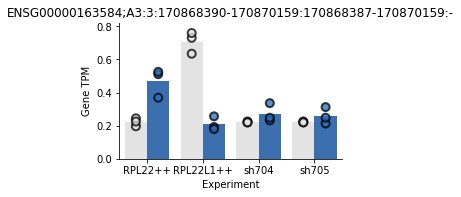

In [55]:
plot_psi_dist("ENSG00000163584;A3:3:170868390-170870159:170868387-170870159:-")

In [51]:
[x for x in exon_psis.columns if "ENSG00000163584" in x]

['ENSG00000163584;A3:3:170868201-170868298:170868134-170868298:-',
 'ENSG00000163584;A3:3:170868390-170870159:170868387-170870159:-',
 'ENSG00000163584;AF:3:170868390-170869965:170870033:170868390-170870159:170870195:-']